In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

from helper_functions import *

In [ ]:
################################################## HELPER FUNCTIONS #################################################################################### 

def plot_2d_3d_pca(data_pca, fuzzy_membership, c,  title, score, initial_centroids=None):
    """
    Plots 2D and 3D PCA projections of data colored by fuzzy membership labels.
    
    Parameters:
    - data_pca: DataFrame containing PCA components (at least PC_1, PC_2, PC_3)
    - fuzzy_membership: array-like, fuzzy cluster assignments (after defuzzification)
    - c: number of clusters
    - title: string, title for the plot
    - score: clustering score (e.g., validation index) to display in the title
    - initial_centroids: optional, initial cluster centers to be plotted
    """
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC_1', y='PC_2', data=data_pca, hue=fuzzy_membership, palette='Set1', 
                    style=fuzzy_membership, markers='o', s=70, alpha=0.6)
    
    if initial_centroids is not None:
        plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], c='black', s=200, marker='X', label='Initial Centers')

    
    plt.title(f"PCA Projection of {title} (Score={score:.4f})")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 0.5))
    plt.show()

    # 3D PCA Visualization for fuzzy partitions
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_pca['PC_1'], data_pca['PC_2'], data_pca['PC_3'], c=fuzzy_membership, cmap='Set1')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'3D PCA Projection of {title} (Score={score:.4f})')
    plt.show()

def plot_svd_projection(x_norm, x_values, y_values, fuzzy_membership):
    """
    Performs SVD on normalized data and visualizes the 2D projection and approximations.
    
    Parameters:
    - x_norm: normalized feature matrix
    - x_values: original feature matrix (before normalization)
    - y_values: target or label values (e.g., wine quality)
    - fuzzy_membership: array-like, fuzzy cluster assignments (after defuzzification)
    """
    u, s, vh = np.linalg.svd(x_norm, full_matrices=True)

    # Projected coordinates of the data points (first two principal components in SVD space)
    u1 = u[:, 0] * s[0]
    u2 = u[:, 1] * s[1]

    # Set data to a Pandas DataFrame for easier plotting
    names_svd = ["U_" + str(x + 1) for x in range(2)]
    names_svd.append('target')
    ds_us = pd.DataFrame(data=np.c_[u1, u2, y_values], columns=names_svd)
    ds_us['target'] = ds_us['target'].astype(int)

    # SVD Projection: Plotting 2D (first two projections)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='U_1', y='U_2', data=ds_us, hue=fuzzy_membership, palette='viridis', 
                    s=70, alpha=0.6, marker='o')  # Use only filled markers ('o')
    plt.title('SVD Projecting Wine Data with Quality Labels')
    plt.xlabel('Projection 1 (SVD)')
    plt.ylabel('Projection 2 (SVD)')
    plt.legend(title='Quality')
    plt.show()

    # Cumulative variance explained by the components
    var_explained = np.cumsum(s**2) / np.sum(s**2) * 100

    # Approximation for different numbers of components
    approx = []
    for n in range(1, x_values.shape[1] + 1):
        approximation = np.dot((u[:, :n] * s[:n]), vh[:n, :])
        approx.append(approximation)

        fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(16, 4))

        sns.regplot(x=approximation[:, 0], y=approximation[:, 2], fit_reg=False, scatter_kws={'alpha': 0.3}, ax=ax1)
        ax1.set(xlabel='Feature 1', ylabel='Feature 3', title=f'{n} component(s) retained, {var_explained[n - 1]:.2f}% variance')

        sns.regplot(x=x_norm[:, 0], y=x_norm[:, 2], fit_reg=False, scatter_kws={'alpha': 0.3}, ax=ax2)
        ax2.set(xlabel='Feature 1', ylabel='Feature 3', title='Original Dataset')

    plt.show()


In [3]:
################################################## DATA PREPARATION #################################################################################### 
# MERGED dataSet
df_r = pd.read_csv("./data/winequality-red.csv", sep=';')
df_w = pd.read_csv("./data/winequality-white.csv", sep=';')
data = pd.concat([df_r, df_w], ignore_index=True)

# Extract features and target
x_values = data.drop(columns=['quality']).values  # features (excluding 'quality')
y_values = data['quality'].values  # target (quality)

x = x_values.astype(np.float32)

# 0 (Default) - Range // 1 - z-score
normalization = 0

# grand means
me = []
# std
std = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# "anomalous cluster" ancl is the data structure to keep everything together
ancl = []
for j in range(x.shape[1]): # for each feature
    z = x[:, j]     # data column vector j-th feature
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    std.append(np.std(z))

    if normalization:
        ranges.append(std[j])
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1
    
x_norm = np.divide((x - me), ranges)

[0.10713504 0.1097492  0.08753414 0.07296683 0.05819087 0.06162512
 0.13022466 0.0578069  0.12463163 0.08359238 0.17284349]
Seed 1 | c=2 | Cost=374.3592 | Xie-Beni=1.3664 | Silhouette=0.2071 | ARI=0.0604
Seed 42 | c=2 | Cost=374.3592 | Xie-Beni=1.3664 | Silhouette=0.2071 | ARI=0.0604
Seed 70 | c=2 | Cost=374.3592 | Xie-Beni=1.3664 | Silhouette=0.2071 | ARI=0.0604
Seed 100 | c=2 | Cost=374.3592 | Xie-Beni=1.3664 | Silhouette=0.2071 | ARI=0.0604
Seed 200 | c=2 | Cost=374.3592 | Xie-Beni=1.3664 | Silhouette=0.2071 | ARI=0.0604
Seed 1 | c=3 | Cost=246.9884 | Xie-Beni=0.6995 | Silhouette=0.2501 | ARI=0.0595
Seed 42 | c=3 | Cost=246.9884 | Xie-Beni=0.6995 | Silhouette=0.2501 | ARI=0.0595
Seed 70 | c=3 | Cost=246.9884 | Xie-Beni=0.6995 | Silhouette=0.2501 | ARI=0.0595
Seed 100 | c=3 | Cost=246.9884 | Xie-Beni=0.6995 | Silhouette=0.2501 | ARI=0.0595
Seed 200 | c=3 | Cost=246.9884 | Xie-Beni=0.6995 | Silhouette=0.2501 | ARI=0.0595
Seed 1 | c=4 | Cost=184.4404 | Xie-Beni=0.9068 | Silhouette=0.15

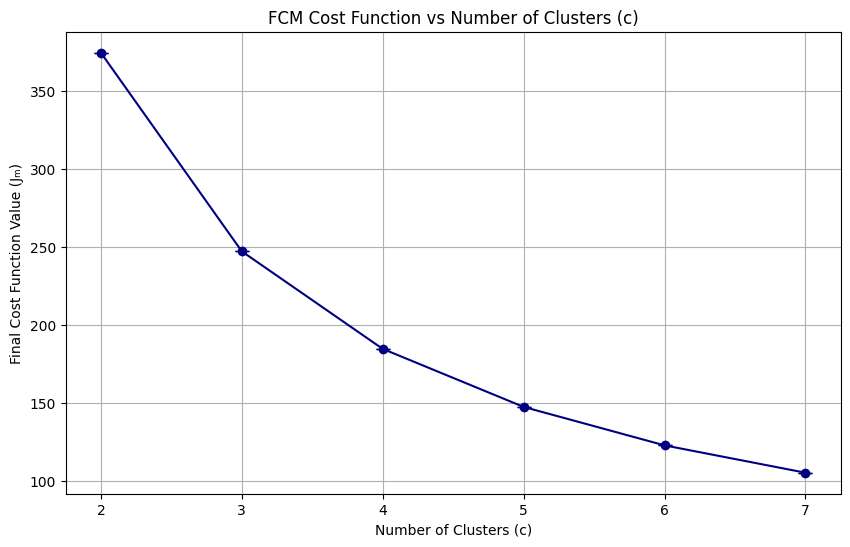

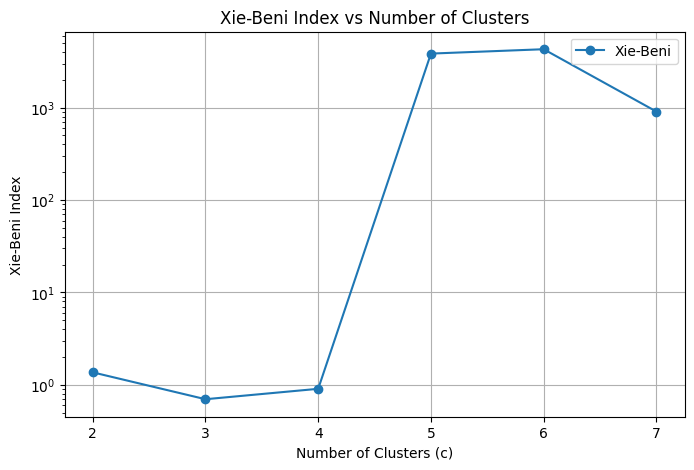

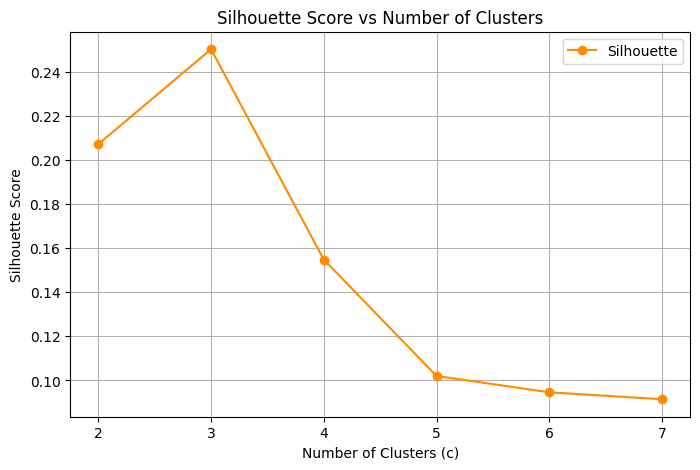

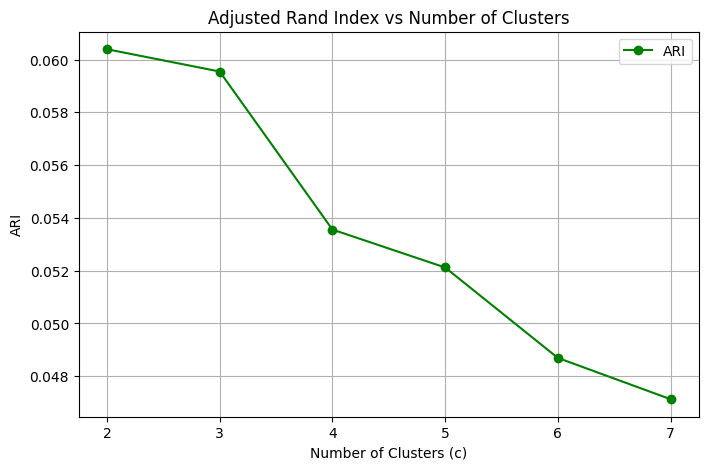


Eigenvalues:
 [0.03726755 0.02737709 0.01885778 0.00916588 0.00759165 0.00497204
 0.00393467 0.00358549 0.00196729 0.00153158 0.00015561]


/tmp/ipykernel_25041/4212942734.py:6: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='PC_1', y='PC_2', data=data_pca, hue=fuzzy_membership, palette='Set1',


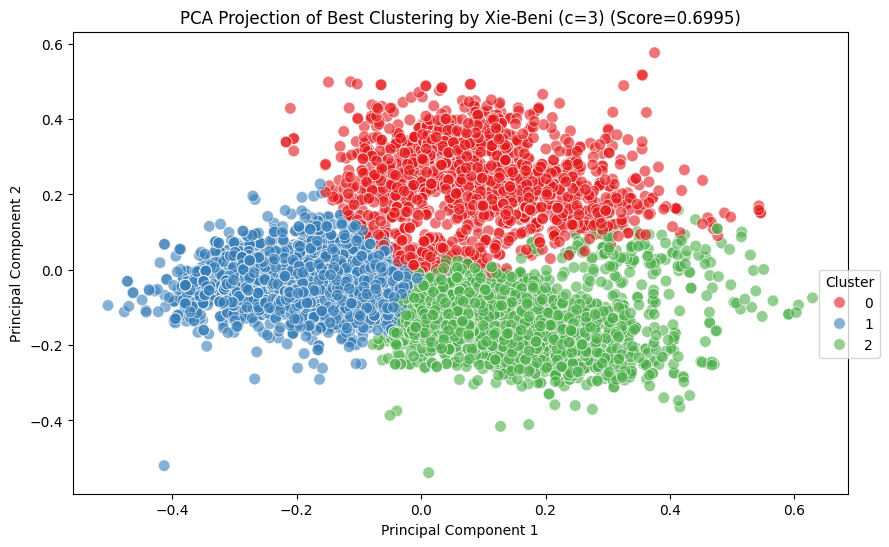

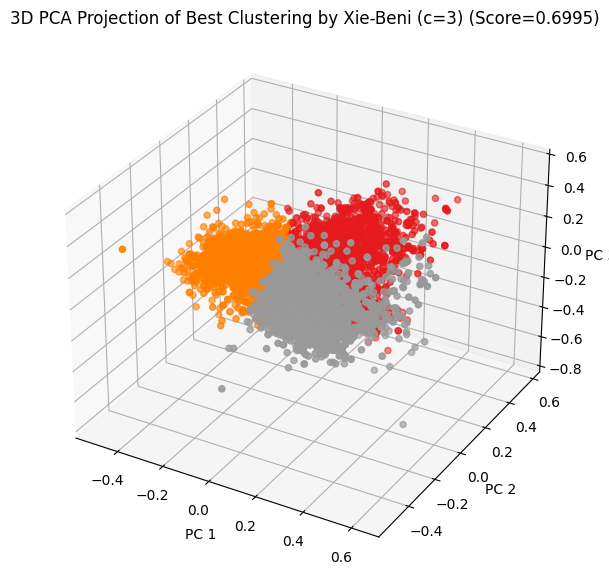

/tmp/ipykernel_25041/4212942734.py:6: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='PC_1', y='PC_2', data=data_pca, hue=fuzzy_membership, palette='Set1',


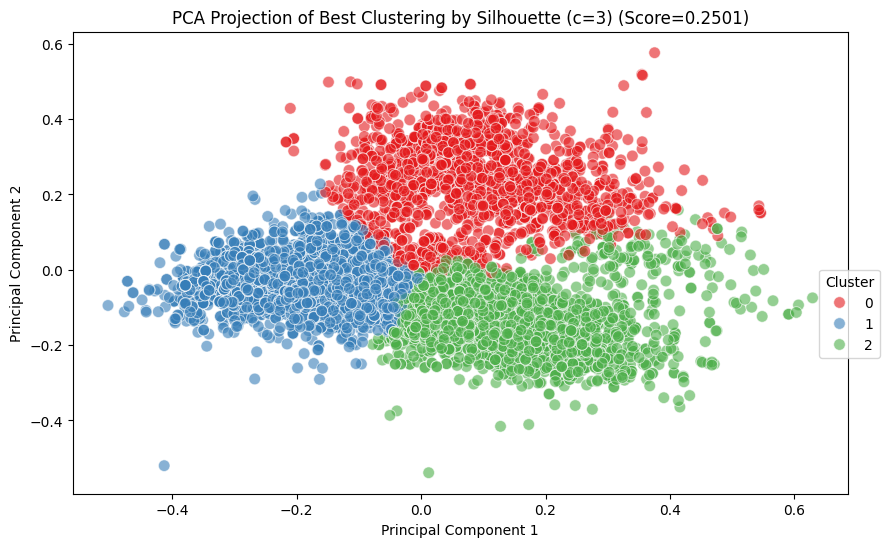

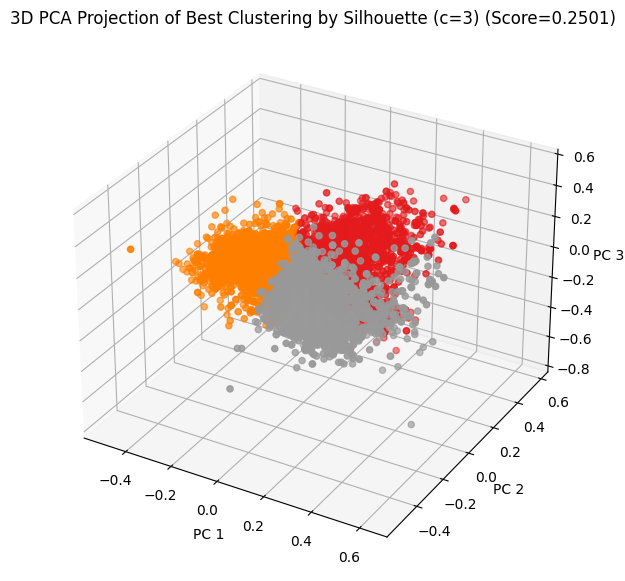

/tmp/ipykernel_25041/4212942734.py:6: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='PC_1', y='PC_2', data=data_pca, hue=fuzzy_membership, palette='Set1',


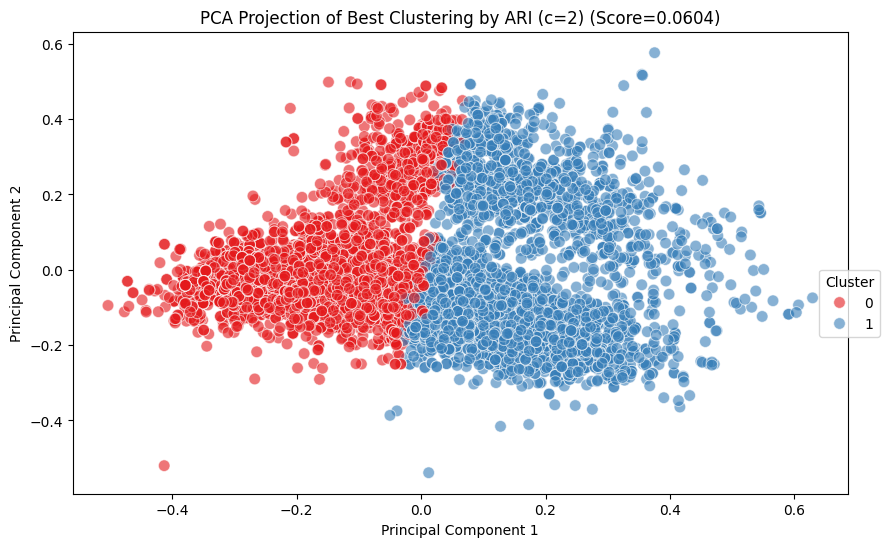

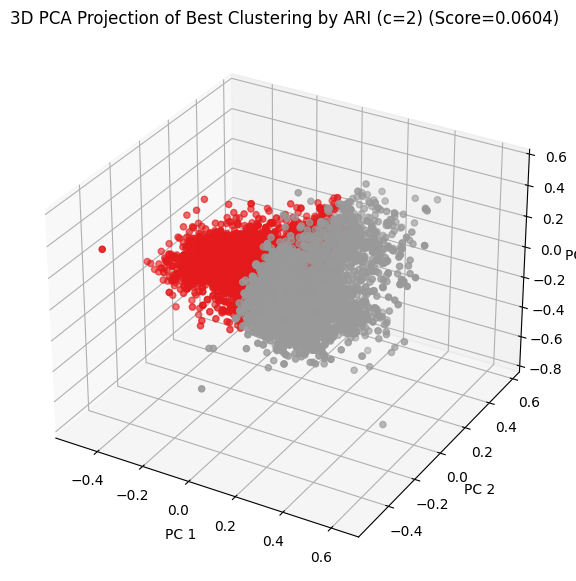

In [4]:
seeds=[1, 42, 70, 100, 200]

print(np.std(x_norm, axis=0))

# FCM 
costs = []
c_values = list(range(2, 8))
# For deviation in cost plots
costs_std = []

# Validations
xie_beni_scores = []
silhouette_scores = []
ari_scores = []

# Best Results for each c
best_results_xie = {}         
best_results_silhouette = {}  
best_results_ari = {}

for c in c_values:
    run_costs = []
    run_xie_beni = []
    run_silhouettes = []
    run_aris = []

    best_xie_beni_score = np.inf
    best_silhouette_score = -1.0
    best_ari_score = -1.0

    best_result_xie = None
    best_result_silhouette = None
    best_result_ari = None
    
    for seed in seeds:
        #centers = cluster centers (c, features)
        #fm = final matrix (c, samples)
        #im = initial matrix (c, samples)
        #d = distance from each cluster to each sample (c, samples)
        #jm = history of cost functions for each iteration
        centers, fm, im, d, jm, i, fpc = fuzz.cluster.cmeans(x_norm.T, c, 2.0, 1e-5, 100, init=None, seed=seed)
        
        # FCM Cost Function
        run_costs.append(jm[-1])
        labels = np.argmax(fm, axis=0)

        # Xie-Beni
        xie_score = xie_beni_index(fm, centers, x_norm)
        run_xie_beni.append(xie_score)
        if xie_score < best_xie_beni_score:
            best_xie_beni_score = xie_score
            best_result_xie = (centers, fm, xie_score, labels)

        # Silhouette
        sil_score = silhouette_score(x_norm, labels)
        run_silhouettes.append(sil_score)
        if sil_score > best_silhouette_score:
            best_silhouette_score = sil_score
            best_result_silhouette = (centers, fm, sil_score, labels)

        # ARI
        ari_score = adjusted_rand_score(y_values, labels)
        run_aris.append(ari_score)
        if ari_score > best_ari_score:
            best_ari_score = ari_score
            best_result_ari = (centers, fm, ari_score, labels)


        print(f"Seed {seed} | c={c} | Cost={jm[-1]:.4f} | Xie-Beni={xie_score:.4f} | Silhouette={sil_score:.4f} | ARI={ari_score:.4f}")

    # Store averages
    xie_beni_scores.append(np.mean(run_xie_beni))
    silhouette_scores.append(np.mean(run_silhouettes))
    ari_scores.append(np.mean(run_aris))
    costs.append(np.mean(run_costs))
    costs_std.append(np.std(run_costs))

    # Store best results
    best_results_xie[c] = best_result_xie
    best_results_silhouette[c] = best_result_silhouette
    best_results_ari[c] = best_result_ari
    

# Cost function vs c
plt.figure(figsize=(10, 6))
plt.errorbar(c_values, costs, yerr=costs_std, fmt='-o', capsize=5, color='navy')
plt.title("FCM Cost Function vs Number of Clusters (c)")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Final Cost Function Value (Jₘ)")
plt.grid(True)

plt.show()

# Xie-Beni
plt.figure(figsize=(8, 5))
plt.plot(c_values, xie_beni_scores, marker='o', label='Xie-Beni')
plt.title("Xie-Beni Index vs Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Xie-Beni Index")
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

# Silhouette
plt.figure(figsize=(8, 5))
plt.plot(c_values, silhouette_scores, marker='o', color='darkorange', label='Silhouette')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.legend()
plt.show()

# ARI
plt.figure(figsize=(8, 5))
plt.plot(c_values, ari_scores, marker='o', color='green', label='ARI')
plt.title("Adjusted Rand Index vs Number of Clusters")
plt.xlabel("Number of Clusters (c)")
plt.ylabel("ARI")
plt.grid(True)
plt.legend()
plt.show()


################################################################ PCA #####################################################################################

data_pca = pca_application(x_norm, y_values)


# Best by Xie-Beni
best_c_xie = c_values[np.argmin(xie_beni_scores)]
centers, fm, score, labels = best_results_xie[best_c_xie]
plot_2d_3d_pca(data_pca, np.argmax(fm, axis=0), len(centers), f"Best Clustering by Xie-Beni (c={best_c_xie})", score)

# Best by Silhouette
best_c_sil = c_values[np.argmax(silhouette_scores)]
centers, fm, score, labels = best_results_silhouette[best_c_sil]
plot_2d_3d_pca(data_pca, np.argmax(fm, axis=0), len(centers), f"Best Clustering by Silhouette (c={best_c_sil})", score)

# Best by ARI
best_c_ari = c_values[np.argmax(ari_scores)]
centers, fm, score, labels = best_results_ari[best_c_ari]
plot_2d_3d_pca(data_pca, np.argmax(fm, axis=0), len(centers), f"Best Clustering by ARI (c={best_c_ari})", score)

################################################################ SVD #####################################################################################

#plot_svd_projection(x_norm, x_values, y_values, fuzzy_membership)